# Análisis Estadístico y Geoespacial de la Sismicidad en el Sureste de México (1975-2025)

**Autor:** Edgar Ivan Morales Herrera  
**Fecha:** Noviembre 2025

## 1. Resumen
El sureste de México es una región de alta complejidad tectónica donde interactúan las placas de Cocos, Norteamérica y el Caribe. Este proyecto analiza el catálogo sísmico de la región (USGS) para caracterizar patrones temporales y espaciales. El estudio se centra en distinguir entre tendencias sismológicas reales y sesgos introducidos por la evolución de la instrumentación científica.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygmt
from matplotlib.colors import ListedColormap

## 2. Carga y Limpieza de Datos
Se utilizan datos históricos desde 1950. Sin embargo, para garantizar la fiabilidad estadística, se aplica un filtro a partir de **1975** y magnitudes **M >= 3.5**, periodo en el cual la red de monitoreo global comenzó a tener una cobertura más consistente.

In [10]:
# Carga de datos (Ajustar ruta si es necesario)
try:
    datos = pd.read_csv('./../datos/1950_2025.csv')
    print("Datos cargados correctamente.")
except FileNotFoundError:
    print("Archivo no encontrado. Verifica la ruta del CSV.")

# Conversión de fechas
datos['time'] = pd.to_datetime(datos.time)
datos = datos.sort_values('time')

# FILTRO DE CALIDAD: 
# Nos quedamos con datos >= 1975 y Magnitud >= 3.5 para evitar sesgos de completitud
datos = datos[datos.time.dt.year >= 1975]
datos = datos[datos.mag >= 3.5]

# Variable de control para conteo
datos['control_ed'] = 1

print(f"Registros después del filtrado: {len(datos)}")

Datos cargados correctamente.
Registros después del filtrado: 9310


### 2.1 Ingeniería de Características (Feature Engineering)
Generamos columnas auxiliares para agrupar eventos por periodos (trimestres, cuatrimestres) y facilitar el análisis temporal.

In [3]:
# Funciones auxiliares para agrupación temporal
def anyo_bim(x):
    mes = int(str(x)[5:7])
    if (mes>=1)&(mes<3): mes_ = '01'
    elif (mes>=3)&(mes<5): mes_ = '03'
    elif (mes>=5)&(mes<7): mes_ = '05'
    elif (mes>=7)&(mes<9): mes_ = '07'
    elif (mes>=9)&(mes<11): mes_ = '09'
    elif (mes>=11): mes_ = '11'
    return str(x)[:5] + mes_

def anyo_cuatri(x):
    mes = int(str(x)[5:7])
    if (mes>=1)&(mes<5): mes_ = '01'
    elif (mes>=5)&(mes<9): mes_ = '05'
    elif (mes>=9): mes_ = '09'
    return str(x)[:5] + mes_

datos['anyo_mes_bim'] = pd.to_datetime(datos.time.apply(anyo_bim))
datos['anyo_mes_cuatri'] = pd.to_datetime(datos.time.apply(anyo_cuatri))

# Agrupaciones para gráficas
datos_count_cuatri_mag = datos[['anyo_mes_cuatri','mag','control_ed']].groupby(by=['anyo_mes_cuatri','mag']).count().reset_index()

In [11]:
#la siguiente función extrae de la fecha el año y el mes
# es util porque podríamos necesitar ignorar la fecha exacta para graficar
def anyo_mes(x):
    return str(x)[:7]

# se crea una columna nueva con datos de año y mes del evento
datos['anyo_mes'] = datos.time.apply(anyo_mes)
datos['anyo_mes'] = pd.to_datetime(datos.anyo_mes)


#la siguiente función extrae de la fecha el año y el semestre del evento
# con 01 si está en el primer semestre o 07 si está en el segundo semestre del año
# es util porque podríamos necesitar ignorar la fecha exacta para graficar
def anyo_sem(x):
    mes = int(str(x)[5:7])
    if mes > 6:
        mes_ = '07'
    else:
        mes_ = '01'
    return str(x)[:5] + mes_

# se crea una columna nueva con datos de año y semestre del evento
datos['anyo_mes_sem'] = datos.time.apply(anyo_sem)
datos['anyo_mes_sem'] = pd.to_datetime(datos.anyo_mes_sem)


#la siguiente función extrae de la fecha el año y el bimestre del evento
# con 01 si está en el primer bimestre, 03 si está en el segundo bimestre del año, ect.
# es util porque podríamos necesitar ignorar la fecha exacta para graficar
def anyo_bim(x):
    mes = int(str(x)[5:7])
    if (mes>=1)&(mes<3):
        mes_ = '01'
    elif (mes>=3)&(mes<5):
        mes_ = '03'
    elif (mes>=5)&(mes<7):
        mes_ = '05'
    elif (mes>=7)&(mes<9):
        mes_ = '07'
    elif (mes>=9)&(mes<11):
        mes_ = '09'
    elif (mes>=11):
        mes_ = '11'
    return str(x)[:5] + mes_

# se crea una columna nueva con datos de año y bimmestre del evento
datos['anyo_mes_bim'] = datos.time.apply(anyo_bim)
datos['anyo_mes_bim'] = pd.to_datetime(datos.anyo_mes_bim)


#la siguiente función extrae de la fecha el año y el trimestre del evento
# con 01 si está en el primer trimestre, 04 si está en el segundo trimestre del año, ect.
# es util porque podríamos necesitar ignorar la fecha exacta para graficar
def anyo_trim(x):
    mes = int(str(x)[5:7])
    if (mes>=1)&(mes<4):
        mes_ = '01'
    elif (mes>=4)&(mes<7):
        mes_ = '04'
    elif (mes>=7)&(mes<10):
        mes_ = '07'
    elif (mes>=10):
        mes_ = '10'
    return str(x)[:5] + mes_

# se crea una columna nueva con datos de año y trimmestre del evento
datos['anyo_mes_trim'] = datos.time.apply(anyo_trim)
datos['anyo_mes_trim'] = pd.to_datetime(datos.anyo_mes_trim)


#la siguiente función extrae de la fecha el año y el cuatrimestre del evento
# con 01 si está en el primer cuatrimestre, 05 si está en el segundo cuatrimestre del año, ect.
# es util porque podríamos necesitar ignorar la fecha exacta para graficar
def anyo_cuatri(x):
    mes = int(str(x)[5:7])
    if (mes>=1)&(mes<5):
        mes_ = '01'
    elif (mes>=5)&(mes<9):
        mes_ = '05'
    elif (mes>=9):
        mes_ = '09'
    return str(x)[:5] + mes_

# se crea una columna nueva con datos de año y trimmestre del evento
datos['anyo_mes_cuatri'] = datos.time.apply(anyo_cuatri)
datos['anyo_mes_cuatri'] = pd.to_datetime(datos.anyo_mes_cuatri)

datos['control_ed'] = 1

In [14]:
datos_count_mes_mag = datos[['anyo_mes_bim','mag','control_ed']].groupby(by=['anyo_mes_bim','mag']).count().reset_index()
datos_count_sem_mag = datos[['anyo_mes_sem','mag','control_ed']].groupby(by=['anyo_mes_sem','mag']).count().reset_index()
datos_count_trim_mag = datos[['anyo_mes_trim','mag','control_ed']].groupby(by=['anyo_mes_trim','mag']).count().reset_index()
datos_count_cuatri_mag = datos[['anyo_mes_cuatri','mag','control_ed']].groupby(by=['anyo_mes_cuatri','mag']).count().reset_index()

## 3. Análisis Temporal: ¿Está aumentando la sismicidad?

Al observar la gráfica de eventos por año, se nota una tendencia creciente. Es crucial interpretar esto con cuidado científico:

**Interpretación:** El incremento visible, especialmente en sismos de magnitud baja (< 5.0), **no implica necesariamente una mayor actividad geológica**, sino una **mejora en la capacidad de detección** (más estaciones, equipos digitales, mejor telemetría) por parte del Servicio Sismológico Nacional y agencias globales. La Tierra no tiembla más; nosotros escuchamos mejor.

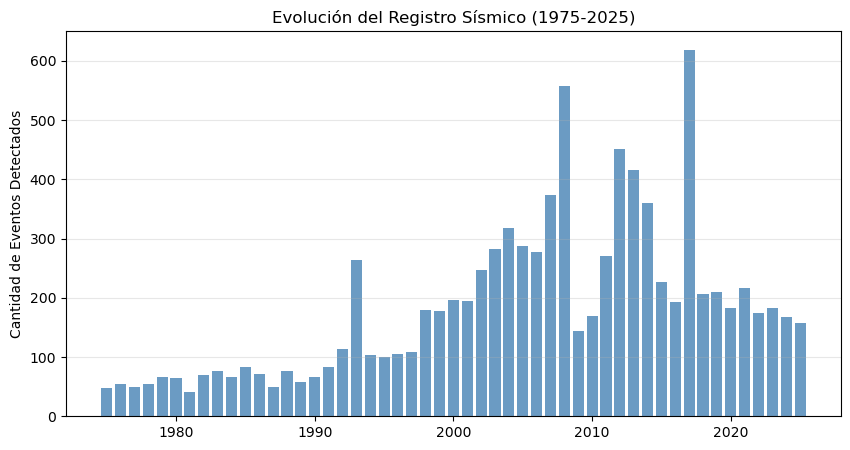

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
anyo = datos.time.dt.year.value_counts().sort_index().index
count = datos.time.dt.year.value_counts().sort_index().values

ax.bar(anyo, count, color='steelblue', alpha=0.8)
ax.set_ylabel('Cantidad de Eventos Detectados')
ax.set_title('Evolución del Registro Sísmico (1975-2025)')
ax.grid(axis='y', alpha=0.3)
plt.show()

### 3.1 Distribución Magnitud-Tiempo
El siguiente gráfico de dispersión muestra la relación entre la fecha y la magnitud. Note cómo la densidad de puntos pequeños aumenta con el tiempo (reflejo de la instrumentación), mientras que los grandes terremotos (puntos altos) ocurren con una frecuencia menos ordenada.

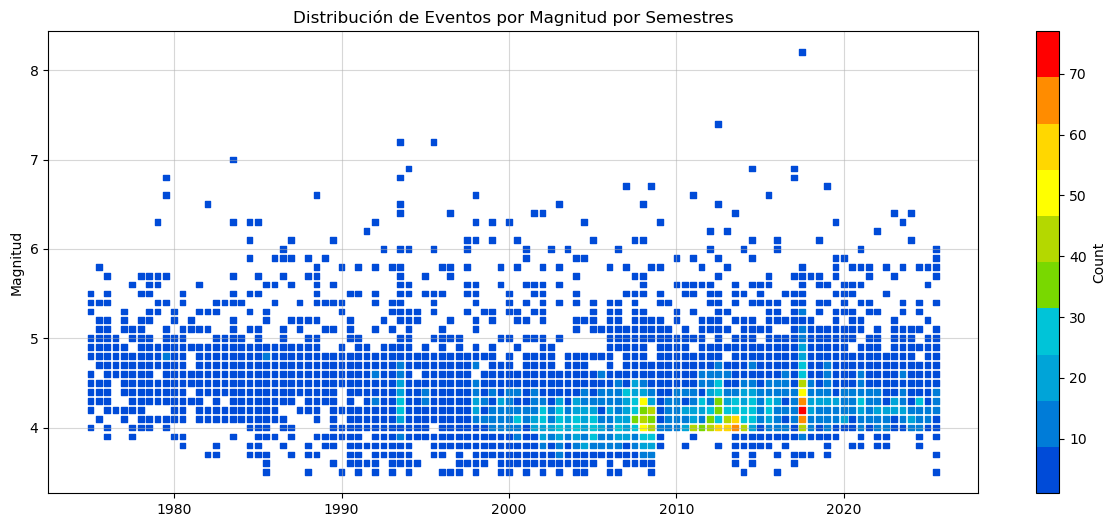

In [15]:
fecha = datos_count_sem_mag.anyo_mes_sem
magnitud = datos_count_sem_mag.mag
cantidad = datos_count_sem_mag.control_ed

plt.figure(figsize=(15,6))
#plt.figure(figsize=(12,4))

color = ListedColormap(['#004bd8','#007cd8','#00a4d8',"#00c4d8", "#79d800", "#b4d800","yellow", "gold","darkorange", "red"])
plt.scatter(fecha, magnitud, c=cantidad, cmap=color, 
            #s=19,
            s=17,
            marker='s')# s=area, c=colors, alpha=0.5)
#ax.set_ylabel('Cantidad por bimestre y por magnitud')
#plt.set_title('magnitud')
plt.ylabel('Magnitud')
plt.title('Distribución de Eventos por Magnitud por Semestres')
plt.colorbar(label = 'Count')
plt.grid(alpha=.5)
plt.savefig('Time_Magnitude_Distribution.pdf')
#en horizontal cada cuadrito representa un semestre a lo largo del tiempo

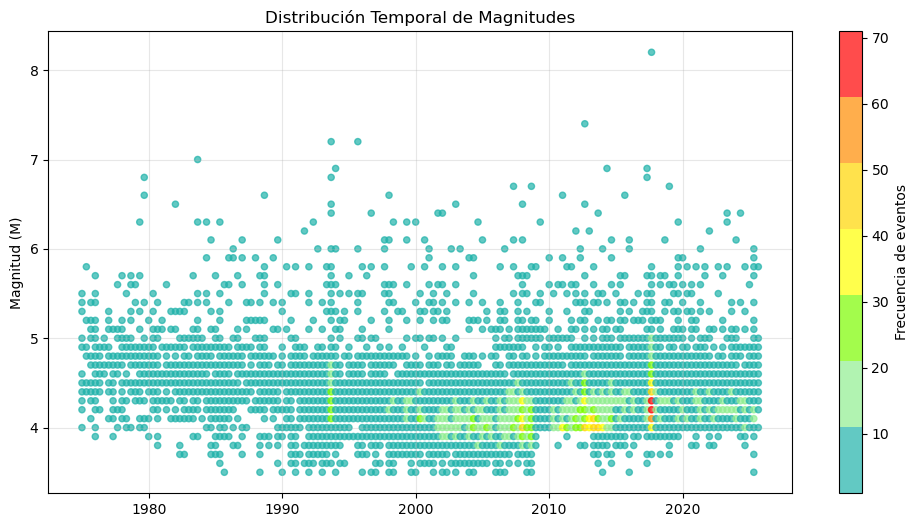

In [5]:
fecha = datos_count_cuatri_mag.anyo_mes_cuatri
magnitud = datos_count_cuatri_mag.mag
cantidad = datos_count_cuatri_mag.control_ed

plt.figure(figsize=(12, 6))
color = ListedColormap(["lightseagreen", "lightgreen", "lawngreen","yellow", "gold","darkorange", "red"])

sc = plt.scatter(fecha, magnitud, c=cantidad, cmap=color, s=20, marker='o', alpha=0.7)
plt.ylabel('Magnitud (M)')
plt.title('Distribución Temporal de Magnitudes')
plt.colorbar(sc, label='Frecuencia de eventos')
plt.grid(alpha=0.3)
plt.show()

## 4. Análisis Espacial (Mapa Tectónico)
Utilizando **PyGMT**, visualizamos la distribución espacial de los epicentros. Este mapa permite identificar la geometría de la zona de subducción (Fosa Mesoamericana), donde la sismicidad se alinea con la interacción de placas.

In [18]:
# Set the region for the plot to be slightly larger than the datos bounds.
region = [
    datos.longitude.min() - 0.2,
    datos.longitude.max() + 0.2,
    datos.latitude.min() - 0.2,
    datos.latitude.max() + 0.2,
]

print(region)

[np.float64(-95.21000000000001), np.float64(-89.8006), np.float64(12.807300000000001), np.float64(18.197)]


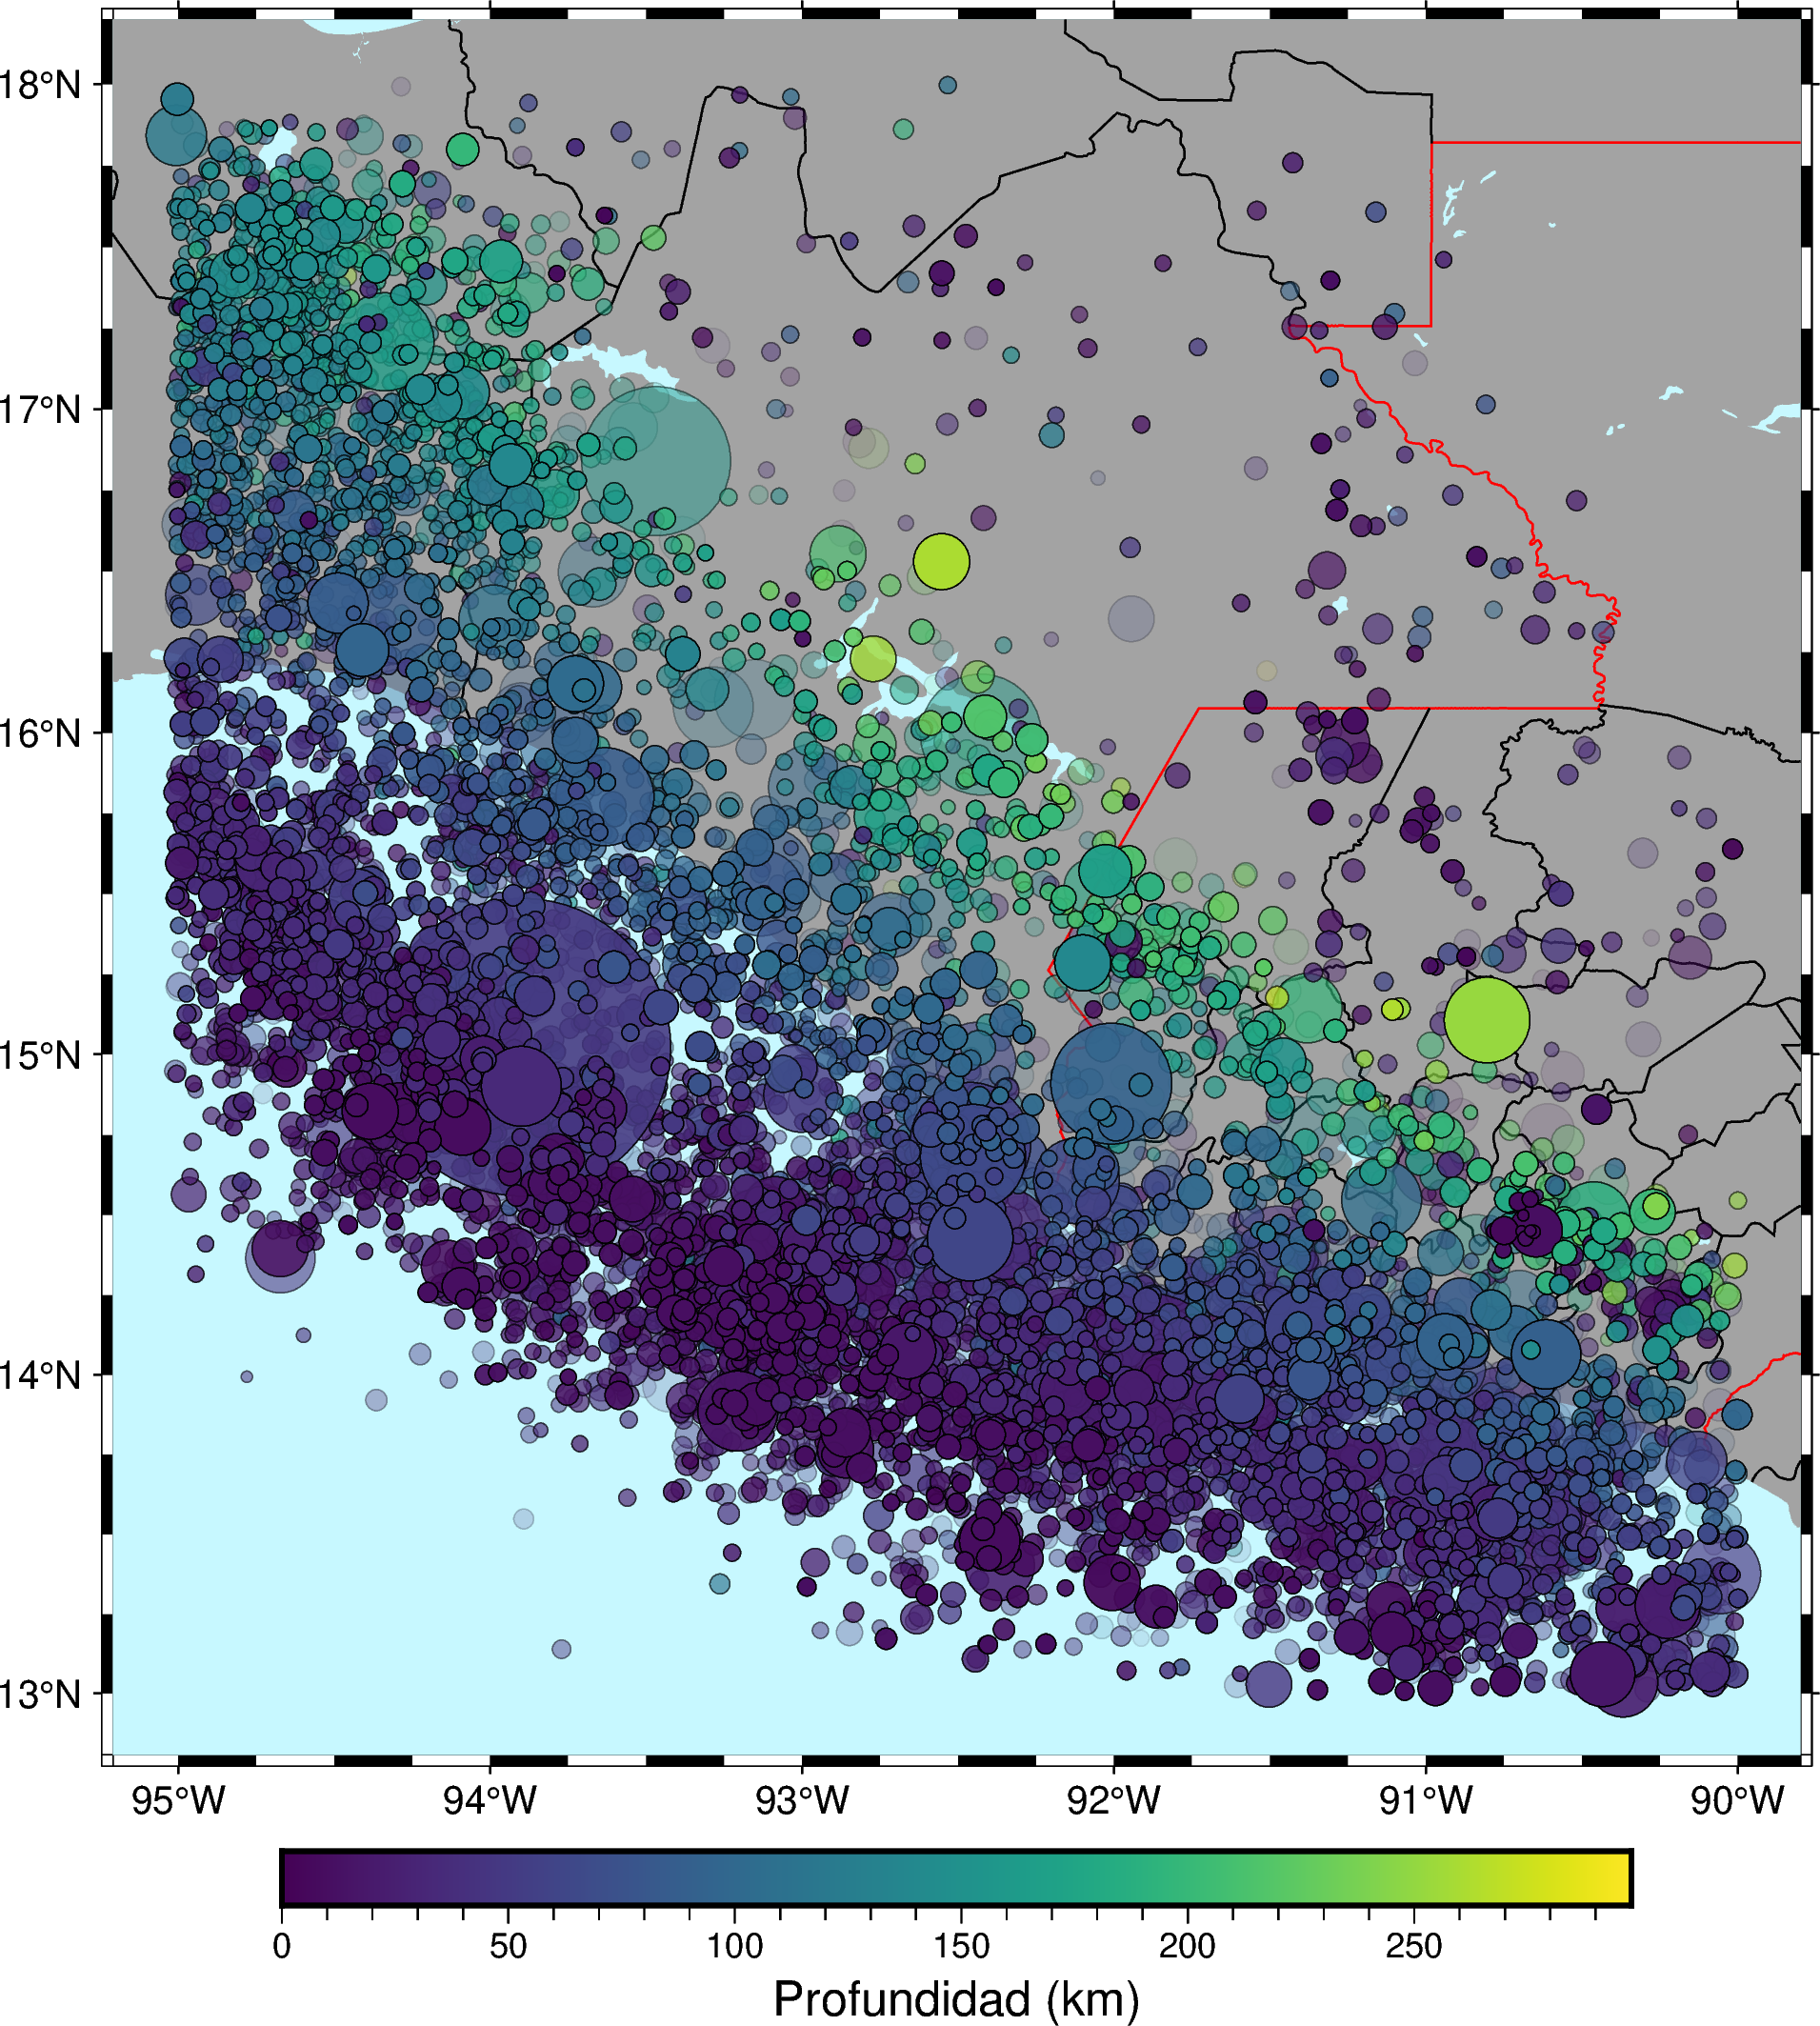

In [19]:
# También podemos asignar los colores de los marcadores a las profundidades
# pasando una matriz al parámetro de relleno y proporcionando un nombre de mapa de colores (cmap).
# Incluso podemos usar el nuevo mapa de colores de matplotlib “viridis”.
# Aquí, primero creamos un mapa de colores continuo que va desde la profundidad mínima
# hasta la profundidad máxima de los terremotos usando pygmt.makecpt,
# luego configuramos cmap=True en pygmt.Figure.plot para usar el mapa de colores.
# Al final de la trama, también trazamos una barra de colores que muestra el mapa de colores utilizado en la trama.

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="#a3a3a3", water="#c7f8ff", borders=["1/0.5p,red", "2/0.5p,black"])
pygmt.makecpt(cmap="viridis", series=[datos.depth.min(), datos.depth.max()])

fig.plot(
    x=datos.longitude,
    y=datos.latitude,
    size=0.009 * 2**datos.mag,
    fill=datos.depth,
    cmap=True,
    style="cc",
    pen="black",
    transparency = 90+(90*(datos.time.dt.year.min()-datos.time.dt.year)/48)
)
fig.colorbar(frame="af+lProfundidad (km)")
#fig.savefig('eventos_profundidad.pdf')
fig.show()

In [17]:
# # Configuración del Mapa con PyGMT

# try:
#     region = [
#         datos.longitude.min() - 1,
#         datos.longitude.max() + 1,
#         datos.latitude.min() - 1,
#         datos.latitude.max() + 1,
#     ]

#     fig = pygmt.Figure()
#     fig.basemap(region=region, projection="M15c", frame=True)
#     fig.coast(land="gray", water="lightblue", shorelines=True)

#     # Colorear por profundidad (cmap='geo') o magnitud
#     pygmt.makecpt(cmap="jet", series=[datos.depth.min(), datos.depth.max()])

#     fig.plot(
#         x=datos.longitude,
#         y=datos.latitude,
#         size=0.05 * (2**datos.mag), # Tamaño proporcional a magnitud exponencial
#         fill=datos.depth,
#         cmap=True,
#         style="c",
#         pen="black"
#     )

#     fig.colorbar(frame='af+l"Profundidad (km)"')
#     fig.show()
#     # fig.savefig("mapa_sismicidad_chiapas.png")
# except Exception as e:
#     print(f"No se pudo generar el mapa PyGMT: {e}")
#     print("Verifica que tengas PyGMT instalado y configurado.")

## 5. Conclusiones
1.  **Instrumentación vs. Realidad:** El análisis confirma que el aumento en la frecuencia de eventos reportados es principalmente un artefacto de la mejora tecnológica en la red de detección.
2.  **Riesgo Sísmico Latente:** A pesar de las fluctuaciones en la detección de sismos menores, la ocurrencia de sismos mayores (M > 6.0) mantiene una constancia estocástica propia de una zona de subducción activa.
3.  **Valor de los Datos:** La limpieza de datos históricos (filtrado por año y magnitud de completitud) es esencial para evitar conclusiones erróneas en estudios de amenaza sísmica.